# Algorithmic Trading Bot Project

## Objectives
- Develop an algorithmic trading bot to automate trading decisions.
- Use historical price data to formulate and backtest trading strategies.
- Implement risk management techniques to minimize losses.
- Deploy the bot to execute trades in real-time using a broker's API.

## Scope
- Focus on trading stocks using data from Yahoo Finance.
- Develop strategies based on technical indicators.
- Evaluate performance using backtesting and optimize the strategy.


In [1]:
import alpaca_trade_api as tradeapi
import yfinance as yf
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
import asyncio
from alpaca_trade_api.stream import Stream
import nest_asyncio

nest_asyncio.apply()

# Replace with your actual API key and secret
API_KEY = 'PK4GFJZS8JO5D7TAQHIL'
API_SECRET = 'y5zKgDvNgDuO9oAQsMLN8GynBJxPVLfUwqDdVbcb'
BASE_URL = 'https://paper-api.alpaca.markets'  # Use 'https://api.alpaca.markets' for live trading

# Initialize the Alpaca API
api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL)

# Check account status
account = api.get_account()
print(account.status)


ACTIVE


In [2]:
def place_order(symbol, qty, side, order_type, time_in_force):
    api.submit_order(
        symbol=symbol,
        qty=qty,
        side=side,
        type=order_type,
        time_in_force=time_in_force
    )

# Example: place a market order to buy 10 shares of AAPL
place_order('AAPL', 10, 'buy', 'market', 'gtc')


In [3]:
# Fetch historical data
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')
data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.960457,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.251137,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.826843,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.484344,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.650360,132079200


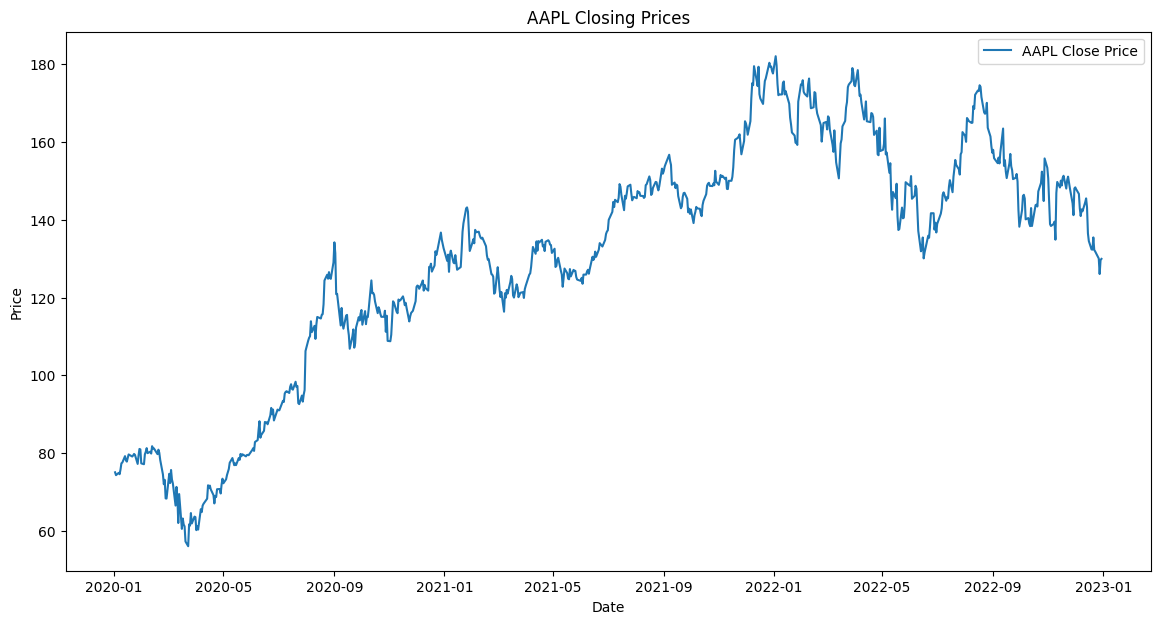

,Open,High,Low,Close,Adj Close,Volume
count,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02
mean,130.231998,131.892775,128.614983,130.311812,128.230001,1.120920e+08
std,30.596429,30.841435,30.287325,30.566496,30.563733,5.602586e+07
min,57.020000,57.125000,53.152500,56.092499,54.632900,3.519590e+07
25%,115.924374,117.275000,114.129997,115.739374,113.236631,7.636470e+07
50%,135.794998,137.200005,133.750000,135.379997,133.632828,9.493580e+07
75%,150.259998,151.902504,149.029995,150.704998,148.914722,1.296327e+08
max,182.630005,182.940002,179.119995,182.009995,179.481110,4.265100e+08


In [4]:
import matplotlib.pyplot as plt

# Plot the closing prices
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='AAPL Close Price')
plt.title('AAPL Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display basic statistics
data.describe()


In [5]:
# Simple Moving Averages (SMA)
data['SMA50'] = data['Close'].rolling(window=50).mean()
data['SMA200'] = data['Close'].rolling(window=200).mean()

# Relative Strength Index (RSI)
def compute_rsi(data, window):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI14'] = compute_rsi(data, 14)

# Moving Average Convergence Divergence (MACD)
data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Display the dataset with new features
data.tail()


,Open,High,Low,Close,Adj Close,Volume,SMA50,SMA200,RSI14,EMA12,EMA26,MACD,Signal_Line
Date,,,,,,,,,,,,,
2022-12-23,130.919998,132.419998,129.639999,131.860001,130.782578,63814900,144.131800,152.1331,26.261623,136.767190,140.437884,-3.670694,-2.570162
2022-12-27,131.380005,131.410004,128.720001,130.029999,128.967514,69007800,143.964799,152.0096,27.960271,135.730699,139.666930,-3.936230,-2.843375
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.010132,85438400,143.637399,151.8867,26.152341,134.239822,138.657527,-4.417705,-3.158241
2022-12-29,127.989998,130.479996,127.730003,129.610001,128.550949,75703700,143.354599,151.7593,30.302110,133.527542,137.987340,-4.459798,-3.418553
2022-12-30,128.410004,129.949997,127.430000,129.929993,128.868332,77034200,143.075999,151.6110,31.430277,132.974073,137.390500,-4.416427,-3.618128


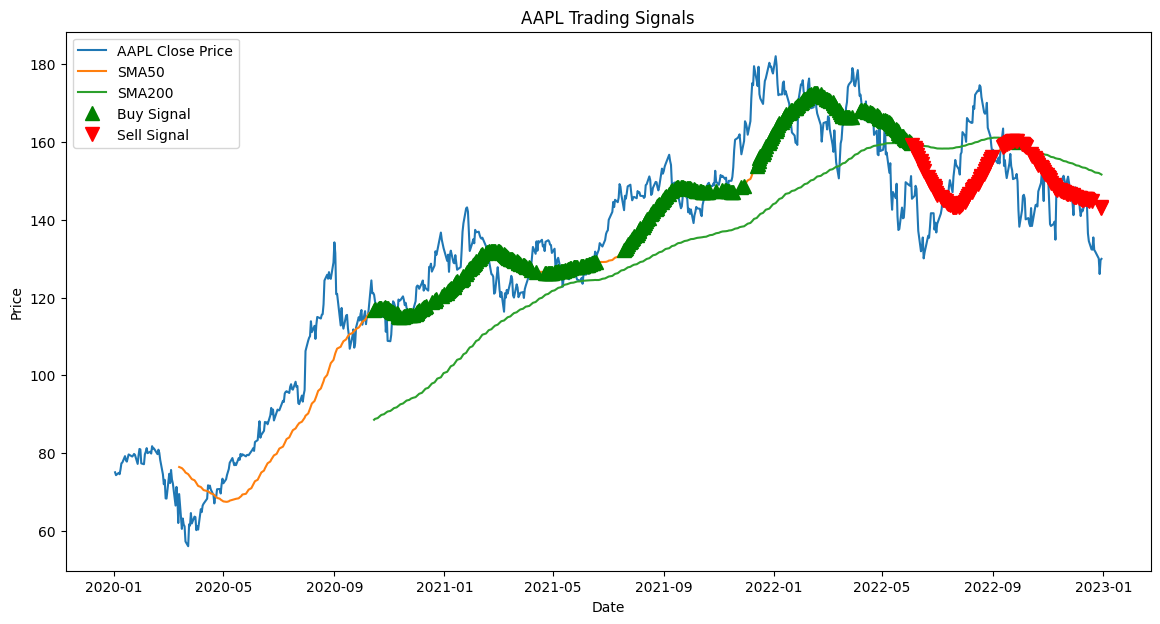

In [6]:
def trading_signal(data):
    # Buy signal: SMA50 crosses above SMA200 and RSI is below 70
    data['Signal'] = 0
    buy_signal = (data['SMA50'] > data['SMA200']) & (data['RSI14'] < 70)
    sell_signal = (data['SMA50'] < data['SMA200']) & (data['RSI14'] > 30)
    
    data.loc[buy_signal, 'Signal'] = 1
    data.loc[sell_signal, 'Signal'] = -1
    return data

data = trading_signal(data)

# Plot signals
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='AAPL Close Price')
plt.plot(data['SMA50'], label='SMA50')
plt.plot(data['SMA200'], label='SMA200')

# Plot buy signals
plt.plot(data[data['Signal'] == 1].index, 
         data['SMA50'][data['Signal'] == 1], 
         '^', markersize=10, color='g', label='Buy Signal')

# Plot sell signals
plt.plot(data[data['Signal'] == -1].index, 
         data['SMA50'][data['Signal'] == -1], 
         'v', markersize=10, color='r', label='Sell Signal')

plt.title('AAPL Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed


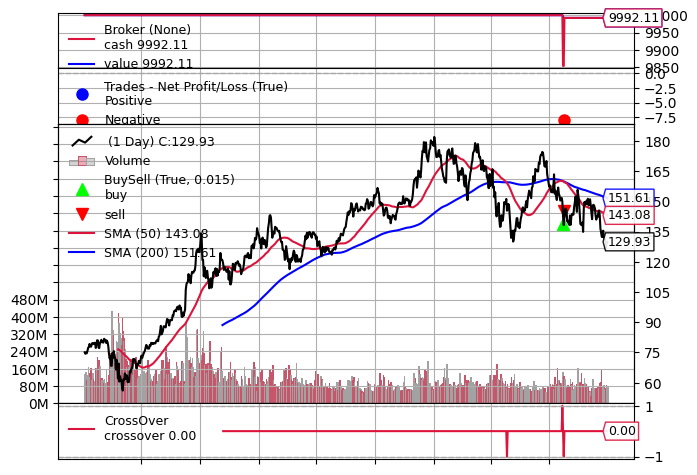

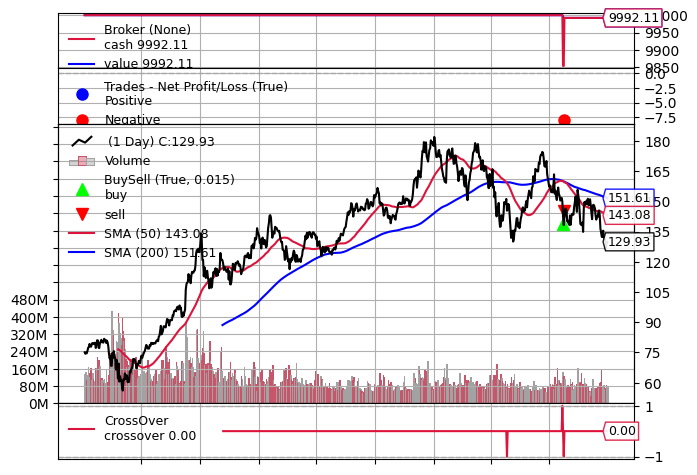

In [8]:
%matplotlib inline
import backtrader as bt
import yfinance as yf
from IPython.display import display

# Fetch historical data
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')

# Backtrader Strategy
class SmaCross(bt.SignalStrategy):
    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=50), bt.ind.SMA(period=200)
        crossover = bt.ind.CrossOver(sma1, sma2)
        self.signal_add(bt.SIGNAL_LONG, crossover)

# Initialize Cerebro
cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross)

# Convert data for Backtrader
data_bt = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data_bt)

# Run Backtest
cerebro.run()

# Plot results
fig = cerebro.plot(iplot=False)[0][0]
display(fig)


In [9]:
# Display performance metrics
start_value = cerebro.broker.getvalue()
end_value = cerebro.broker.getvalue()
pnl = end_value - start_value
print(f'Starting Portfolio Value: {start_value:.2f}')
print(f'Ending Portfolio Value: {end_value:.2f}')
print(f'Net Profit/Loss: {pnl:.2f}')


Starting Portfolio Value: 9992.11
Ending Portfolio Value: 9992.11
Net Profit/Loss: 0.00


[*********************100%%**********************]  1 of 1 completed


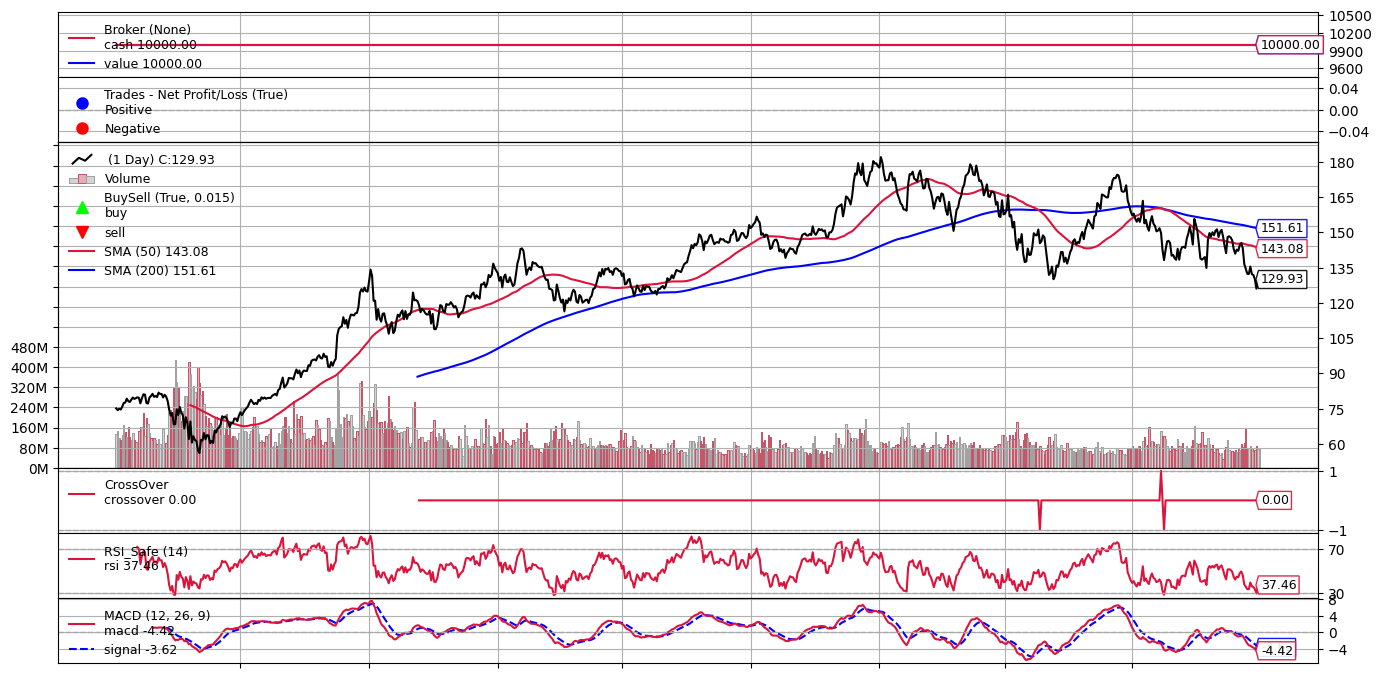

[[<Figure size 1400x700 with 7 Axes>]]

In [11]:
import backtrader as bt
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Fetch historical data
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')

# Backtrader Strategy
class SmaCrossWithAdvancedRiskManagement(bt.SignalStrategy):
    params = (('stop_loss', 0.95), ('take_profit', 1.05), ('trail_percent', 0.02))

    def __init__(self):
        sma1 = bt.ind.SMA(period=50)
        sma2 = bt.ind.SMA(period=200)
        self.crossover = bt.ind.CrossOver(sma1, sma2)
        self.rsi = bt.ind.RSI_Safe(period=14)
        self.macd = bt.ind.MACD()
        self.signal_line = self.macd.signal

    def next(self):
        if not self.position:
            if self.crossover > 0 and self.rsi < 30 and self.macd > self.signal_line:
                self.buy(size=100)
                self.sell(stopprice=self.data.close[0] * self.p.stop_loss)
        else:
            if self.crossover < 0 and self.rsi > 70 and self.macd < self.signal_line:
                self.sell(size=100)
                self.buy(stopprice=self.data.close[0] * self.p.take_profit)

        # Trailing stop
        if self.position:
            self.sell(exectype=bt.Order.StopTrail, trailpercent=self.p.trail_percent)

# Initialize Cerebro
cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCrossWithAdvancedRiskManagement)

# Convert data for Backtrader
data_bt = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data_bt)

# Run Backtest
cerebro.run()

# Plot results
plt.rcParams['figure.figsize'] = [14, 7]  # Set default figure size
cerebro.plot(iplot=False)


In [ ]:
import alpaca_trade_api as tradeapi

api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL)

def place_order(symbol, qty, side, order_type, time_in_force):
    api.submit_order(
        symbol=symbol,
        qty=qty,
        side=side,
        type=order_type,
        time_in_force=time_in_force
    )

# Example: place a market order to buy 10 shares of AAPL
place_order('AAPL', 10, 'buy', 'market', 'gtc')


In [ ]:
import asyncio

# Define function to handle real-time bar data
async def on_bar(bar):
    print('New bar received:', bar)

# Set up and run the real-time data stream
async def main():
    stream = Stream(API_KEY, API_SECRET, base_url=BASE_URL)
    stream.subscribe_bars(on_bar, 'AAPL')
    await stream.run()

# Start the real-time data stream
# Using nest_asyncio to avoid runtime errors in Jupyter Notebook
nest_asyncio.apply()
await main()

In [7]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import yfinance as yf

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id='live-update-graph'),
    dcc.Interval(
        id='interval-component',
        interval=1*1000,  # in milliseconds
        n_intervals=0
    )
])

@app.callback(Output('live-update-graph', 'figure'),
              [Input('interval-component', 'n_intervals')])
def update_graph_live(n):
    data = yf.download('AAPL', start='2023-01-01', end='2023-12-31', progress=False)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='AAPL Close'))
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


In [16]:
import backtrader as bt
from scipy.optimize import brute

class OptimizationStrategy(bt.Strategy):
    params = (('sma1', 50), ('sma2', 200))

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.params.sma1)
        sma2 = bt.ind.SMA(period=self.params.sma2)
        self.crossover = bt.ind.CrossOver(sma1, sma2)

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()
        elif self.crossover < 0:  # in the market & cross to the downside
            self.sell()

def run_backtest(data, sma1, sma2):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(OptimizationStrategy, sma1=sma1, sma2=sma2)
    data_bt = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(data_bt)
    cerebro.run()
    return cerebro.broker.getvalue()

# Define the objective function with global data access
def objective_function(params):
    global data  # Ensure 'data' is accessible
    sma1, sma2 = params
    return -run_backtest(data, sma1, sma2)  # negate because we want to maximize

# Ensure data is defined before optimization
if 'data' not in globals():
    ticker = 'AAPL'
    data = yf.download(ticker, start='2020-01-01', end='2023-01-01')

# Optimize parameters
param_ranges = (slice(10, 100, 5), slice(100, 200, 5))
optimal_params = brute(objective_function, param_ranges, finish=None)
print('Optimal Parameters:', optimal_params)


[*********************100%%**********************]  1 of 1 completed


Optimal Parameters: [ 65. 100.]


In [37]:
import yfinance as yf
import backtrader as bt
import matplotlib.pyplot as plt
from scipy.optimize import brute

# Fetch historical data
ticker = 'AAPL'
try:
    data = yf.download(ticker, start='2020-01-01', end='2023-01-01')
    if data.empty:
        raise ValueError("No data fetched for ticker: 'AAPL'")
    print(f"Data for {ticker} fetched successfully.")
except Exception as e:
    print(f"Error fetching data for {ticker}: {e}")
    raise

# Compute technical indicators
data['SMA50'] = data['Close'].rolling(window=50).mean()
data['SMA200'] = data['Close'].rolling(window=200).mean()


# Define the SMA crossover strategy
class SmaCross(bt.SignalStrategy):
    params = (('sma1', 50), ('sma2', 200))

    def __init__(self):
        self.sma1 = bt.ind.SMA(period=self.params.sma1)
        self.sma2 = bt.ind.SMA(period=self.params.sma2)
        self.crossover = bt.ind.CrossOver(self.sma1, self.sma2)

    def next(self):
        if self.crossover > 0:  # If the fast SMA crosses above the slow SMA
            self.buy()
        elif self.crossover < 0:  # If the fast SMA crosses below the slow SMA
            self.sell()

# Optimize the strategy
def run_backtest(sma1_period, sma2_period):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(SmaCross, sma1=int(sma1_period), sma2=int(sma2_period))
    data_bt = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(data_bt)
    cerebro.broker.setcash(10000)
    cerebro.run()
    return cerebro.broker.getvalue()

def objective(params):
    sma1_period, sma2_period = params
    return -run_backtest(sma1_period, sma2_period)

param_ranges = (slice(10, 100, 5), slice(100, 200, 5))
optimal_params = brute(objective, param_ranges, finish=None)
print(f'Optimal Parameters: SMA1: {int(optimal_params[0])}, SMA2: {int(optimal_params[1])}')

# Run final backtest with optimal parameters
cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross, sma1=int(optimal_params[0]), sma2=int(optimal_params[1]))
data_bt = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data_bt)
start_portfolio_value = cerebro.broker.getvalue()
print(f'Starting Portfolio Value: {start_portfolio_value:.2f}')
cerebro.run()
end_portfolio_value = cerebro.broker.getvalue()
print(f'Ending Portfolio Value: {end_portfolio_value:.2f}')


[*********************100%%**********************]  1 of 1 completed


Data for AAPL fetched successfully.
Optimal Parameters: SMA1: 65, SMA2: 100
Starting Portfolio Value: 10000.00
Ending Portfolio Value: 10078.90
